# Cloning dataset

In [1]:
# This is our GitHub repository, all datasets are included in this repo
!git clone https://github.com/Alvin-Tan-Yi-Tung/Animal_Disease_Prediction.git

fatal: destination path 'Animal_Disease_Prediction' already exists and is not an empty directory.


# Import neccessary libraries & load dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [3]:
df = pd.read_csv("/content/Animal_Disease_Prediction/backend/wahis_outbreak_details.csv")
df

,country,location,lat_long,start_date,end_date,cases,deaths
0,Armenia,Sardarapat,"40.1239 , 44.0044",2025/08/04,2025/08/05,1,1
1,Armenia,Aygeshat,"40.227 , 44.2855",2025/07/29,2025/07/30,1,1
2,Namibia,Walvisbay Lagoon,"-22.96348 , 14.48727",2025/06/16,-,-,1
3,Thailand,Si Sa Ket,"14.951072 , 104.331852",2025/06/30,-,1,1
4,Thailand,Nakhon Ratchasima,"15.552079 , 102.777379",2025/06/23,-,1,1
...,...,...,...,...,...,...,...
2195,France,FONTENAY LE COMTE,"46.45964911 , -0.78859276",2007/11/23,2007/11/29,1,1
2196,Ecuador,San Juan de Bellavista,"-3.41489966 , -79.35188579",2007/03/12,2007/06/01,1,1
2197,Ecuador,Quebrada Honda,"-3.40597651 , -79.35171856",2007/02/20,2007/06/01,1,1
2198,Ecuador,San Carlos,"-0.19417301 , -76.51244951",2007/03/06,2007/08/17,1,1


In [4]:
# Before changing the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country     2200 non-null   object
 1   location    2200 non-null   object
 2   lat_long    2200 non-null   object
 3   start_date  2200 non-null   object
 4   end_date    2200 non-null   object
 5   cases       2200 non-null   object
 6   deaths      2200 non-null   object
dtypes: object(7)
memory usage: 120.4+ KB


# Data Preprocessing

In [5]:
# change country to categorical
df['country'] = df['country'].astype('category')

# change outbreak start date and end date to datetime
df["start_date"] = pd.to_datetime(df["start_date"], format="%Y/%m/%d", errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], format="%Y/%m/%d", errors="coerce")

# change cases and deaths to numerical
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

# Format datetime columns to day/month/year strings
df['start_date'] = df['start_date'].dt.strftime('%d/%m/%Y')
df['end_date'] = df['end_date'].dt.strftime('%d/%m/%Y')

# After changing the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   country     2200 non-null   category
 1   location    2200 non-null   object  
 2   lat_long    2200 non-null   object  
 3   start_date  2200 non-null   object  
 4   end_date    1864 non-null   object  
 5   cases       2191 non-null   float64 
 6   deaths      2047 non-null   float64 
dtypes: category(1), float64(2), object(4)
memory usage: 106.8+ KB


In [6]:
df

,country,location,lat_long,start_date,end_date,cases,deaths
0,Armenia,Sardarapat,"40.1239 , 44.0044",04/08/2025,05/08/2025,1.0,1.0
1,Armenia,Aygeshat,"40.227 , 44.2855",29/07/2025,30/07/2025,1.0,1.0
2,Namibia,Walvisbay Lagoon,"-22.96348 , 14.48727",16/06/2025,NaN,NaN,1.0
3,Thailand,Si Sa Ket,"14.951072 , 104.331852",30/06/2025,NaN,1.0,1.0
4,Thailand,Nakhon Ratchasima,"15.552079 , 102.777379",23/06/2025,NaN,1.0,1.0
...,...,...,...,...,...,...,...
2195,France,FONTENAY LE COMTE,"46.45964911 , -0.78859276",23/11/2007,29/11/2007,1.0,1.0
2196,Ecuador,San Juan de Bellavista,"-3.41489966 , -79.35188579",12/03/2007,01/06/2007,1.0,1.0
2197,Ecuador,Quebrada Honda,"-3.40597651 , -79.35171856",20/02/2007,01/06/2007,1.0,1.0
2198,Ecuador,San Carlos,"-0.19417301 , -76.51244951",06/03/2007,17/08/2007,1.0,1.0


In [7]:
# Replace NaN in date columns with 'Ongoing'
df['start_date'] = df['start_date'].fillna('Ongoing')
df['end_date'] = df['end_date'].fillna('Ongoing')

# Replace NaN in cases and deaths columns with 0
df['cases'] = df['cases'].fillna(0)
df['deaths'] = df['deaths'].fillna(0)

# Display the updated DataFrame to show the changes
display(df.head())

,country,location,lat_long,start_date,end_date,cases,deaths
0,Armenia,Sardarapat,"40.1239 , 44.0044",04/08/2025,05/08/2025,1.0,1.0
1,Armenia,Aygeshat,"40.227 , 44.2855",29/07/2025,30/07/2025,1.0,1.0
2,Namibia,Walvisbay Lagoon,"-22.96348 , 14.48727",16/06/2025,Ongoing,0.0,1.0
3,Thailand,Si Sa Ket,"14.951072 , 104.331852",30/06/2025,Ongoing,1.0,1.0
4,Thailand,Nakhon Ratchasima,"15.552079 , 102.777379",23/06/2025,Ongoing,1.0,1.0


# Total cases and deaths in graph view

/tmp/ipython-input-3728014690.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(x='country', y='cases', data=df.groupby('country')['cases'].sum().reset_index())


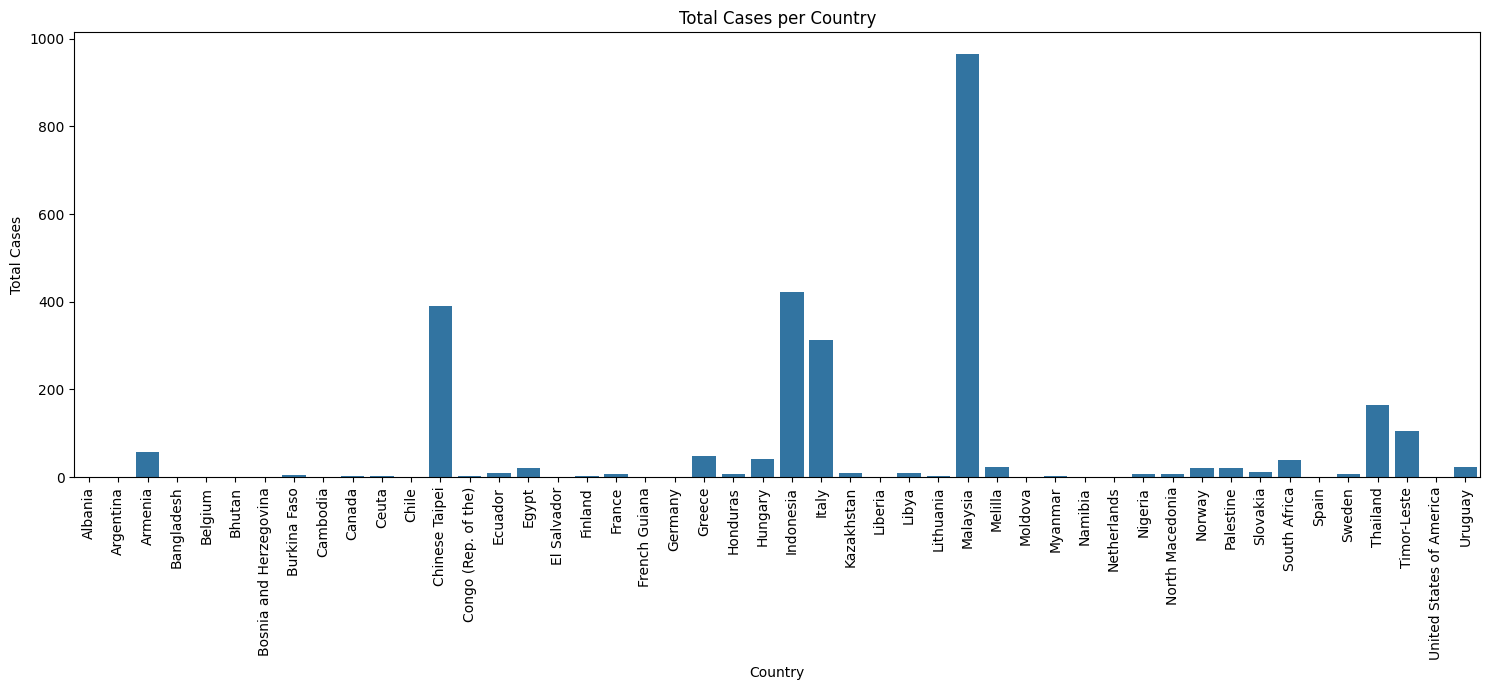

/tmp/ipython-input-3728014690.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(x='country', y='deaths', data=df.groupby('country')['deaths'].sum().reset_index())


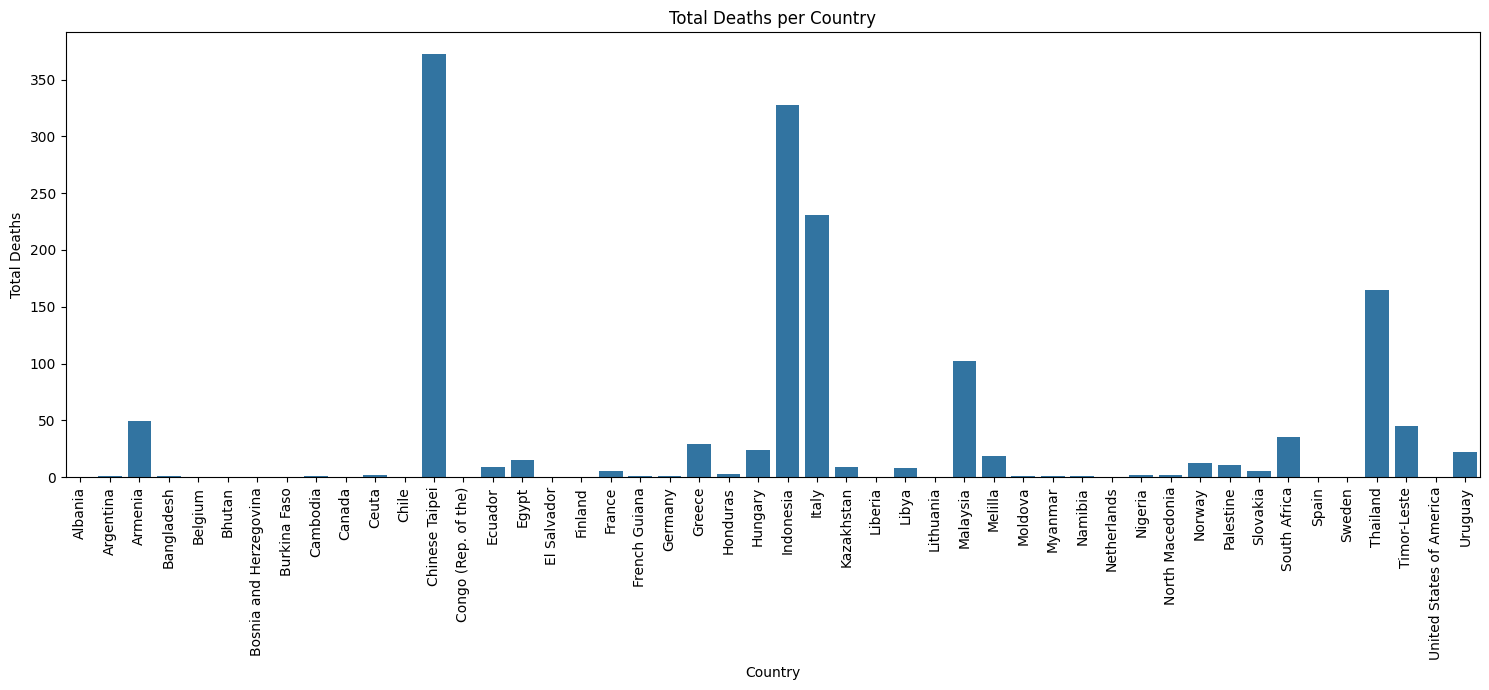

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of cases by country with country names
plt.figure(figsize=(15, 7))
sns.barplot(x='country', y='cases', data=df.groupby('country')['cases'].sum().reset_index())
plt.title('Total Cases per Country')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Distribution of cases by country with country names
plt.figure(figsize=(15, 7))
sns.barplot(x='country', y='deaths', data=df.groupby('country')['deaths'].sum().reset_index())
plt.title('Total Deaths per Country')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Based on the total cases graph, Malaysia ranked top, followed by Indonesia then Chinese Taipei.

Meanwhile, Chinese Taipei has ranked top for the total animal deaths, followed by Indonesia, then Italy and Malaysia.

# Cases and Deaths Table Comparison

In [9]:
# This is to just showing the total cases and deaths of each country, which will be use as features in future AI prediction
from IPython.display import display, HTML

# Table view of total cases per country
total_cases_per_country = df.groupby('country')['cases'].sum().reset_index()
print("\nTotal Cases per Country:")

# Table view of total deaths per country
total_deaths_per_country = df.groupby('country')['deaths'].sum().reset_index()
print("\nTotal Deaths per Country:")

# Display total cases and deaths tables
display(HTML(f"""
    <div style="display: flex;">
        <div style="margin-right: 20px;">
            {total_cases_per_country.to_html(index=False)}
        </div>
        <div>
            {total_deaths_per_country.to_html(index=False)}
        </div>
    </div>
"""))


Total Cases per Country:

Total Deaths per Country:


/tmp/ipython-input-598341312.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_cases_per_country = df.groupby('country')['cases'].sum().reset_index()
/tmp/ipython-input-598341312.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_deaths_per_country = df.groupby('country')['deaths'].sum().reset_index()


country,cases
Albania,0.0
Argentina,1.0
Armenia,58.0
Bangladesh,1.0
Belgium,1.0
Bhutan,0.0
Bosnia and Herzegovina,1.0
Burkina Faso,4.0
Cambodia,1.0
Canada,2.0


# Total outbreak count for Malaysia only

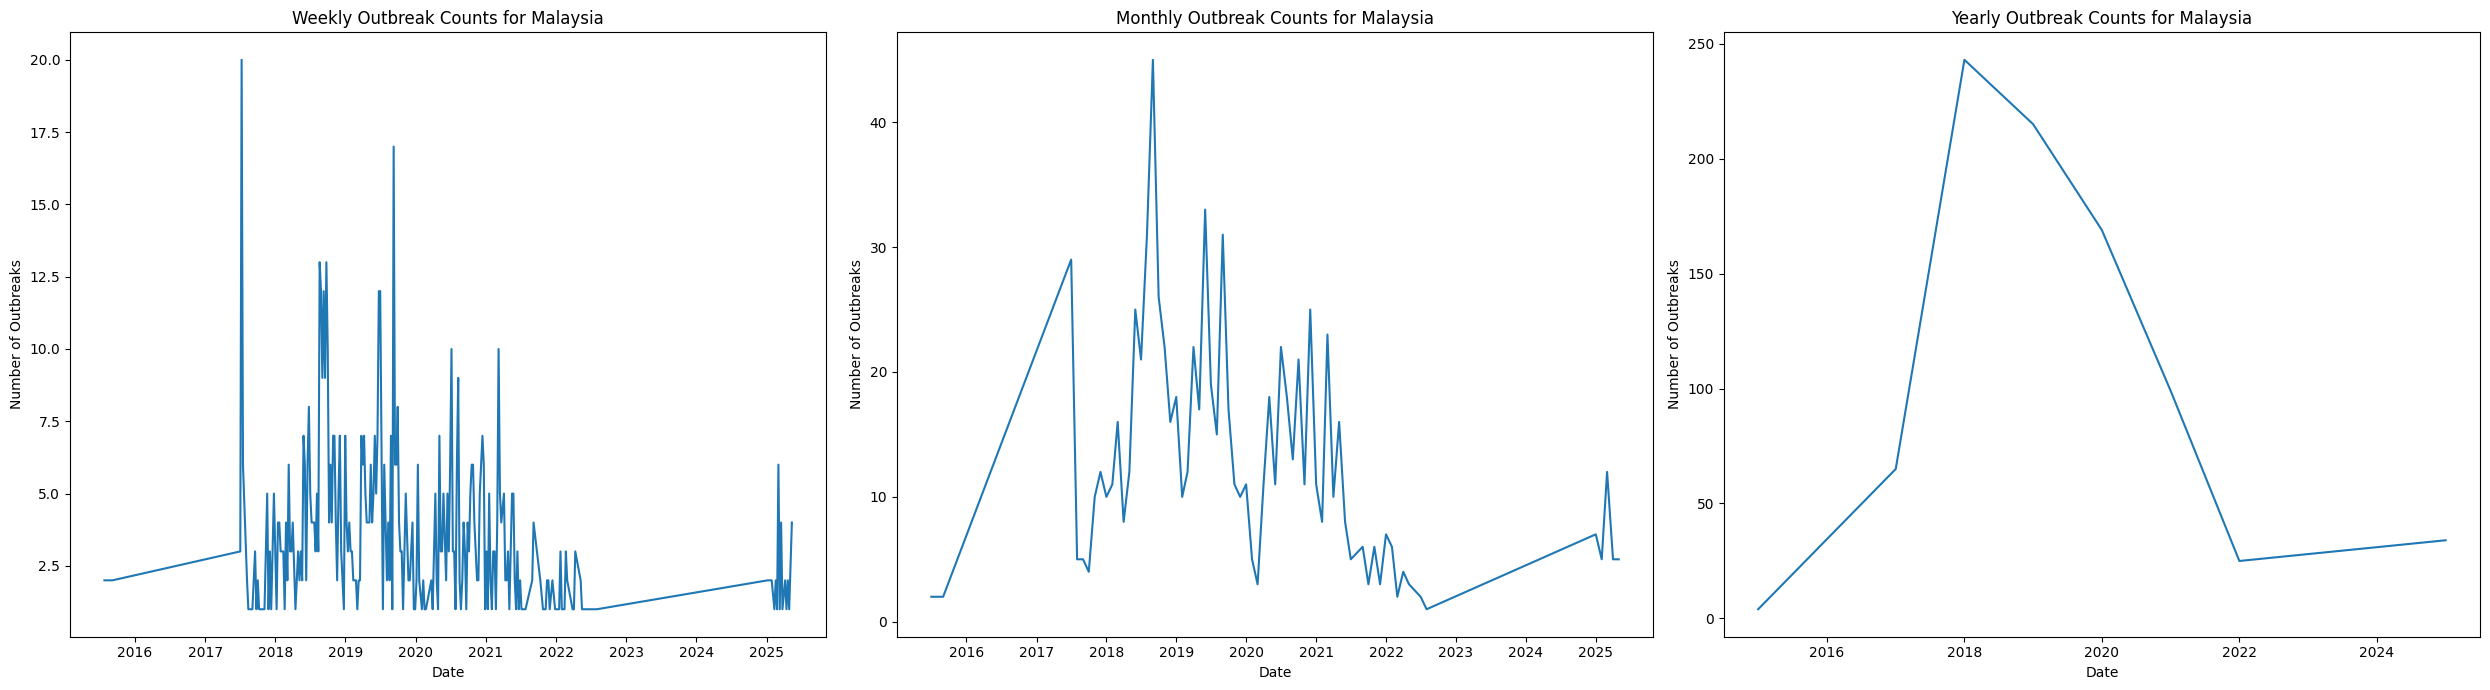

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Time series of start dates by country as a line graph
# Convert 'start_date' to datetime objects first, coercing errors
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y', errors='coerce')

# Filter out rows where start_date could not be parsed (e.g., 'Ongoing')
df_plotting = df.dropna(subset=['start_date'])

# Extract year, month, and week
df_plotting['year_week'] = df_plotting['start_date'].dt.to_period('W')
df_plotting['year_month'] = df_plotting['start_date'].dt.to_period('M')
df_plotting['year'] = df_plotting['start_date'].dt.to_period('Y')


# Group by country and time period and count outbreaks (weekly, monthly and annualy)
outbreak_counts_weekly = df_plotting.groupby(['country', 'year_week'], observed=True).size().reset_index(name='outbreak_count')
outbreak_counts_monthly = df_plotting.groupby(['country', 'year_month'], observed=True).size().reset_index(name='outbreak_count')
outbreak_counts_yearly = df_plotting.groupby(['country', 'year'], observed=True).size().reset_index(name='outbreak_count')


# Convert time period back to datetime for plotting
outbreak_counts_weekly['year_week'] = outbreak_counts_weekly['year_week'].dt.to_timestamp()
outbreak_counts_monthly['year_month'] = outbreak_counts_monthly['year_month'].dt.to_timestamp()
outbreak_counts_yearly['year'] = outbreak_counts_yearly['year'].dt.to_timestamp()


# Filter for Malaysia
malaysia_outbreaks_weekly = outbreak_counts_weekly[outbreak_counts_weekly['country'] == 'Malaysia']
malaysia_outbreaks_monthly = outbreak_counts_monthly[outbreak_counts_monthly['country'] == 'Malaysia']
malaysia_outbreaks_yearly = outbreak_counts_yearly[outbreak_counts_yearly['country'] == 'Malaysia']

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Plot weekly outbreak counts for Malaysia
sns.lineplot(x='year_week', y='outbreak_count', data=malaysia_outbreaks_weekly, ax=axes[0])
axes[0].set_title('Weekly Outbreak Counts for Malaysia')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Outbreaks')


# Plot monthly outbreak counts for Malaysia
sns.lineplot(x='year_month', y='outbreak_count', data=malaysia_outbreaks_monthly, ax=axes[1])
axes[1].set_title('Monthly Outbreak Counts for Malaysia')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Outbreaks')


# Plot yearly outbreak counts for Malaysia
sns.lineplot(x='year', y='outbreak_count', data=malaysia_outbreaks_yearly, ax=axes[2])
axes[2].set_title('Yearly Outbreak Counts for Malaysia')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Outbreaks')


plt.tight_layout()
plt.show()

# Total outbreak count for worldwide

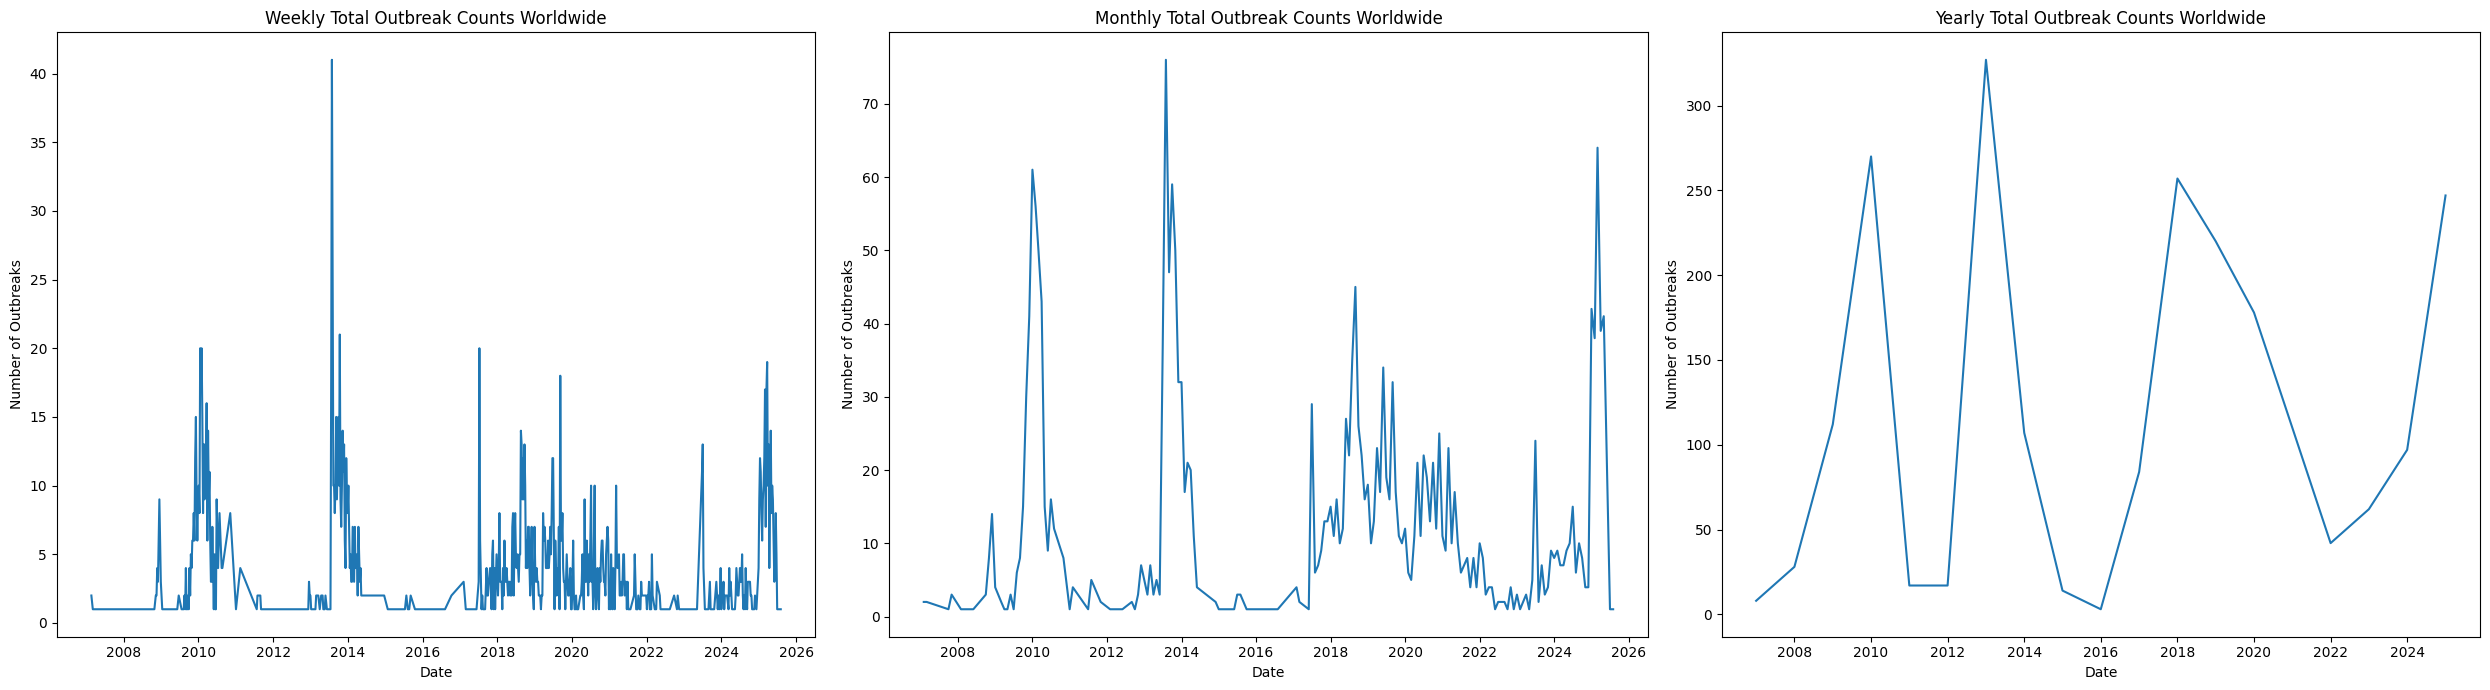

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'start_date' to datetime objects, coercing errors
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y', errors='coerce')

# Filter out rows where start_date could not be parsed
df_plotting = df.dropna(subset=['start_date'])

# Extract year, month, and week
df_plotting['year_week'] = df_plotting['start_date'].dt.to_period('W')
df_plotting['year_month'] = df_plotting['start_date'].dt.to_period('M')
df_plotting['year'] = df_plotting['start_date'].dt.to_period('Y')

# Group by time period and count total outbreaks
total_outbreak_counts_weekly = df_plotting.groupby('year_week', observed=True).size().reset_index(name='outbreak_count')
total_outbreak_counts_monthly = df_plotting.groupby('year_month', observed=True).size().reset_index(name='outbreak_count')
total_outbreak_counts_yearly = df_plotting.groupby('year', observed=True).size().reset_index(name='outbreak_count')

# Convert time period back to datetime for plotting
total_outbreak_counts_weekly['year_week'] = total_outbreak_counts_weekly['year_week'].dt.to_timestamp()
total_outbreak_counts_monthly['year_month'] = total_outbreak_counts_monthly['year_month'].dt.to_timestamp()
total_outbreak_counts_yearly['year'] = total_outbreak_counts_yearly['year'].dt.to_timestamp()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Plot weekly total outbreak counts
sns.lineplot(x='year_week', y='outbreak_count', data=total_outbreak_counts_weekly, ax=axes[0])
axes[0].set_title('Weekly Total Outbreak Counts Worldwide')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Outbreaks')

# Plot monthly total outbreak counts
sns.lineplot(x='year_month', y='outbreak_count', data=total_outbreak_counts_monthly, ax=axes[1])
axes[1].set_title('Monthly Total Outbreak Counts Worldwide')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Outbreaks')

# Plot yearly total outbreak counts
sns.lineplot(x='year', y='outbreak_count', data=total_outbreak_counts_yearly, ax=axes[2])
axes[2].set_title('Yearly Total Outbreak Counts Worldwide')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Outbreaks')

plt.tight_layout()
plt.show()

# Label encoding the features used for LSTM model

In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoders = {}

# Apply label encoding to categorical columns (country and location) -> convert to number code for lstm model to learn
for col in ['country', 'location']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Convert 'start_date' and 'end_date' to datetime objects, coercing errors
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%d/%m/%Y', errors='coerce')

# Create the 'is_ongoing' column
df['is_ongoing'] = df['end_date'].isna() # True if end_date is NaT (originally 'Ongoing' or couldn't be parsed)

# Split 'lat_long' into 'latitude' and 'longitude' and convert to numeric (which maybe used for plotting purpose)
df[['latitude', 'longitude']] = df['lat_long'].str.split(',', expand=True)
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Change cases and deaths to numerical (maybe can use as features)
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

# drop 'lat_long' column as it is no longer use
df = df.drop(columns=['lat_long'])

# Display the updated DataFrame with the new features
display(df.info())
print("\n")
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   country     2200 non-null   int64         
 1   location    2200 non-null   int64         
 2   start_date  2200 non-null   datetime64[ns]
 3   end_date    1864 non-null   datetime64[ns]
 4   cases       2200 non-null   float64       
 5   deaths      2200 non-null   float64       
 6   is_ongoing  2200 non-null   bool          
 7   latitude    2200 non-null   float64       
 8   longitude   2200 non-null   float64       
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2)
memory usage: 139.8 KB


None

,country,location,start_date,end_date,cases,deaths,is_ongoing,latitude,longitude
0,2,1290,2025-08-04,2025-08-05,1.0,1.0,False,40.123900,44.004400
1,2,86,2025-07-29,2025-07-30,1.0,1.0,False,40.227000,44.285500
2,34,1465,2025-06-16,NaT,0.0,1.0,True,-22.963480,14.487270
3,44,1310,2025-06-30,NaT,1.0,1.0,True,14.951072,104.331852
4,44,981,2025-06-23,NaT,1.0,1.0,True,15.552079,102.777379


# Can add deaths total

In [13]:
# Create time period columns
df['Year'] = df['start_date'].dt.year
df['Month'] = df['start_date'].dt.to_period('M')
df['Week'] = df['start_date'].dt.to_period('W')

# Weekly aggregation of cases, deaths and outbreak counts by country
weekly_df = df.groupby(['country', 'Week'], observed=True).agg(
    total_cases=('cases', 'sum'),
    total_deaths=('deaths', 'sum'),
    outbreak_count=('start_date', 'count') # Count non-null start dates as outbreaks
).reset_index()

# Monthly aggregation of cases, deaths and outbreak counts by country
monthly_df = df.groupby(['country', 'Month'], observed=True).agg(
    total_cases=('cases', 'sum'),
    total_deaths=('deaths', 'sum'),
    outbreak_count=('start_date', 'count')
).reset_index()

# Annual aggregation of cases, deaths and outbreak counts by country
annual_df = df.groupby(['country', 'Year'], observed=True).agg(
    total_cases=('cases', 'sum'),
    total_deaths=('deaths', 'sum'),
    outbreak_count=('start_date', 'count')
).reset_index()

# Display the first few rows of each aggregated DataFrame
print("Weekly Aggregation:")
display(weekly_df.head())

print("\nMonthly Aggregation:")
display(monthly_df.head())

print("\nAnnual Aggregation:")
display(annual_df.head())

# Save the aggregated dataframes to CSV files
weekly_df.to_csv('weekly_outbreaks_by_country.csv', index=False)
monthly_df.to_csv('monthly_outbreaks_by_country.csv', index=False)
annual_df.to_csv('annual_outbreaks_by_country.csv', index=False)

Weekly Aggregation:


,country,Week,total_cases,total_deaths,outbreak_count
0,0,2012-06-04/2012-06-10,0.0,0.0,1
1,0,2012-09-10/2012-09-16,0.0,0.0,1
2,1,2008-11-10/2008-11-16,1.0,1.0,1
3,2,2018-06-04/2018-06-10,1.0,0.0,1
4,2,2019-03-25/2019-03-31,1.0,1.0,1



Monthly Aggregation:


,country,Month,total_cases,total_deaths,outbreak_count
0,0,2012-06,0.0,0.0,1
1,0,2012-09,0.0,0.0,1
2,1,2008-11,1.0,1.0,1
3,2,2018-06,1.0,0.0,1
4,2,2019-03,1.0,1.0,1



Annual Aggregation:


,country,Year,total_cases,total_deaths,outbreak_count
0,0,2012,0.0,0.0,2
1,1,2008,1.0,1.0,1
2,2,2018,1.0,0.0,1
3,2,2019,2.0,2.0,2
4,2,2020,4.0,1.0,4


In [14]:
# This is to save the step before into the csv files
weekly_df = pd.read_csv('weekly_outbreaks_by_country.csv')
monthly_df = pd.read_csv('monthly_outbreaks_by_country.csv')
annual_df = pd.read_csv('annual_outbreaks_by_country.csv')

weekly_df.info()
print("\n")
monthly_df.info()
print("\n")
annual_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         727 non-null    int64  
 1   Week            727 non-null    object 
 2   total_cases     727 non-null    float64
 3   total_deaths    727 non-null    float64
 4   outbreak_count  727 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 28.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         342 non-null    int64  
 1   Month           342 non-null    object 
 2   total_cases     342 non-null    float64
 3   total_deaths    342 non-null    float64
 4   outbreak_count  342 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 13.5+ KB


<class 'pandas.core.frame.DataFr

In [15]:
# This part the step and configuration is almost the same, this is make the lstm model to be more context
# Focus on weekly data
weekly_df['Week'] = weekly_df['Week'].astype(str)  # convert Period to str for processing
weekly_agg = weekly_df.groupby('Week').agg(
    outbreak_count=('outbreak_count', 'sum'),
    total_cases=('total_cases', 'sum')
).reset_index()

# Sort by time
weekly_agg['Week'] = pd.to_datetime(weekly_agg['Week'].str.split('/').str[0])
weekly_agg = weekly_agg.sort_values('Week')

# Add lagged features for outbreak_count and total_cases with a wider range
for i in range(1, 8): # Lags for 1 to 7 weeks
    weekly_agg[f'outbreak_count_lag_{i}'] = weekly_agg['outbreak_count'].shift(i)
    weekly_agg[f'total_cases_lag_{i}'] = weekly_agg['total_cases'].shift(i)

# Add rolling features for outbreak_count and total_cases with larger window sizes
for window in [3, 5, 7, 14]: # Rolling windows of 3, 5, 7, and 14 weeks
    weekly_agg[f'outbreak_count_rolling_mean_{window}'] = weekly_agg['outbreak_count'].rolling(window=window).mean()
    weekly_agg[f'outbreak_count_rolling_max_{window}'] = weekly_agg['outbreak_count'].rolling(window=window).max()
    weekly_agg[f'total_cases_rolling_mean_{window}'] = weekly_agg['total_cases'].rolling(window=window).mean()
    weekly_agg[f'total_cases_rolling_max_{window}'] = weekly_agg['total_cases'].rolling(window=window).max()

# Drop rows with NaN values created by lagged and rolling features
weekly_agg = weekly_agg.dropna()

# Feature scaling
scaler = MinMaxScaler()
# Exclude the 'Week' column before scaling
scaled_features = scaler.fit_transform(weekly_agg.drop(columns=['Week']))

# Display the first few rows of the dataframe with new features
print("Weekly Aggregation with Features:")
display(weekly_agg.head())
display(pd.DataFrame(scaled_features).head()) # Display scaled features as a DataFrame for clarity


# Focus on monthly data
monthly_df['Month'] = monthly_df['Month'].astype(str)
monthly_agg = monthly_df.groupby('Month').agg(
    outbreak_count=('outbreak_count', 'sum'),
    total_cases=('total_cases', 'sum')
).reset_index()

# Sort by time
monthly_agg['Month'] = pd.to_datetime(monthly_agg['Month'].str.split('/').str[0])
monthly_agg = monthly_agg.sort_values('Month')

# Add Lag & Rolling Features for monthly data
for i in range(1, 4): # Lags for 1 to 3 months
    monthly_agg[f'outbreak_count_lag_{i}'] = monthly_agg['outbreak_count'].shift(i)
    monthly_agg[f'total_cases_lag_{i}'] = monthly_agg['total_cases'].shift(i)

for window in [2, 3, 6]: # Rolling windows of 2, 3, and 6 months
    monthly_agg[f'outbreak_count_rolling_mean_{window}'] = monthly_agg['outbreak_count'].rolling(window=window).mean()
    monthly_agg[f'outbreak_count_rolling_max_{window}'] = monthly_agg['outbreak_count'].rolling(window=window).max()
    monthly_agg[f'total_cases_rolling_mean_{window}'] = monthly_agg['total_cases'].rolling(window=window).mean()
    monthly_agg[f'total_cases_rolling_max_{window}'] = monthly_agg['total_cases'].rolling(window=window).max()

monthly_agg = monthly_agg.dropna()

# Feature scaling for monthly data
monthly_scaler = MinMaxScaler()
scaled_monthly_features = monthly_scaler.fit_transform(monthly_agg.drop(columns=['Month']))

print("\nMonthly Aggregation with Features:")
display(monthly_agg.head())
display(pd.DataFrame(scaled_monthly_features).head())


# Focus on annual data
annual_agg = annual_df.groupby('Year').agg(
    outbreak_count=('outbreak_count', 'sum'),
    total_cases=('total_cases', 'sum')
).reset_index()

# Sort by time
annual_agg = annual_agg.sort_values('Year')

# Add Lag & Rolling Features for annual data
for i in range(1, 3): # Lags for 1 to 2 years
    annual_agg[f'outbreak_count_lag_{i}'] = annual_agg['outbreak_count'].shift(i)
    annual_agg[f'total_cases_lag_{i}'] = annual_agg['total_cases'].shift(i)

for window in [2, 3]: # Rolling windows of 2 and 3 years
    annual_agg[f'outbreak_count_rolling_mean_{window}'] = annual_agg['outbreak_count'].rolling(window=window).mean()
    annual_agg[f'outbreak_count_rolling_max_{window}'] = annual_agg['outbreak_count'].rolling(window=window).max()
    annual_agg[f'total_cases_rolling_mean_{window}'] = annual_agg['total_cases'].rolling(window=window).mean()
    annual_agg[f'total_cases_rolling_max_{window}'] = annual_agg['total_cases'].rolling(window=window).max()

annual_agg = annual_agg.dropna()

# Feature scaling for annual data
annual_scaler = MinMaxScaler()
scaled_annual_features = annual_scaler.fit_transform(annual_agg.drop(columns=['Year']))

print("\nAnnual Aggregation with Features:")
display(annual_agg.head())
display(pd.DataFrame(scaled_annual_features).head())

Weekly Aggregation with Features:


,Week,outbreak_count,total_cases,outbreak_count_lag_1,total_cases_lag_1,outbreak_count_lag_2,total_cases_lag_2,outbreak_count_lag_3,total_cases_lag_3,outbreak_count_lag_4,...,total_cases_rolling_mean_5,total_cases_rolling_max_5,outbreak_count_rolling_mean_7,outbreak_count_rolling_max_7,total_cases_rolling_mean_7,total_cases_rolling_max_7,outbreak_count_rolling_mean_14,outbreak_count_rolling_max_14,total_cases_rolling_mean_14,total_cases_rolling_max_14
13,2008-11-10,2,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.2,2.0,1.142857,2.0,1.142857,2.0,1.142857,2.0,1.500000,7.0
14,2008-11-17,2,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,...,1.2,2.0,1.285714,2.0,1.285714,2.0,1.142857,2.0,1.142857,2.0
15,2008-11-24,4,4.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,...,1.8,4.0,1.714286,4.0,1.714286,4.0,1.357143,4.0,1.357143,4.0
16,2008-12-01,3,8.0,4.0,4.0,2.0,2.0,2.0,2.0,1.0,...,3.2,8.0,2.000000,4.0,2.571429,8.0,1.500000,4.0,1.857143,8.0
17,2008-12-15,9,10.0,3.0,8.0,4.0,4.0,2.0,2.0,2.0,...,5.2,10.0,3.142857,9.0,3.857143,10.0,2.071429,9.0,2.500000,10.0


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.025,0.010417,0.000,0.000000,0.000,0.005208,0.000,0.005208,0.000,0.010417,...,0.013115,0.005236,0.008696,0.025,0.013072,0.005236,0.010050,0.025,0.025890,0.026316
1,0.025,0.010417,0.025,0.010417,0.000,0.000000,0.000,0.005208,0.000,0.005208,...,0.013115,0.005236,0.017391,0.025,0.016340,0.005236,0.010050,0.025,0.009709,0.000000
2,0.075,0.020833,0.025,0.010417,0.025,0.010417,0.000,0.000000,0.000,0.005208,...,0.022951,0.015707,0.043478,0.075,0.026144,0.015707,0.025126,0.075,0.019417,0.010526
3,0.050,0.041667,0.075,0.020833,0.025,0.010417,0.025,0.010417,0.000,0.000000,...,0.045902,0.036649,0.060870,0.075,0.045752,0.036649,0.035176,0.075,0.042071,0.031579
4,0.200,0.052083,0.050,0.041667,0.075,0.020833,0.025,0.010417,0.025,0.010417,...,0.078689,0.047120,0.130435,0.200,0.075163,0.047120,0.075377,0.200,0.071197,0.042105



Monthly Aggregation with Features:


,Month,outbreak_count,total_cases,outbreak_count_lag_1,total_cases_lag_1,outbreak_count_lag_2,total_cases_lag_2,outbreak_count_lag_3,total_cases_lag_3,outbreak_count_rolling_mean_2,...,total_cases_rolling_mean_2,total_cases_rolling_max_2,outbreak_count_rolling_mean_3,outbreak_count_rolling_max_3,total_cases_rolling_mean_3,total_cases_rolling_max_3,outbreak_count_rolling_mean_6,outbreak_count_rolling_max_6,total_cases_rolling_mean_6,total_cases_rolling_max_6
5,2008-04-01,1,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.666667,3.0,1.666667,3.0,1.666667,3.0,2.500000,7.0
6,2008-06-01,1,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,...,1.5,2.0,1.000000,1.0,1.333333,2.0,1.500000,3.0,1.666667,3.0
7,2008-10-01,3,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,2.0,2.0,1.666667,3.0,1.666667,2.0,1.666667,3.0,1.666667,3.0
8,2008-11-01,8,8.0,3.0,2.0,1.0,2.0,1.0,1.0,5.5,...,5.0,8.0,4.000000,8.0,4.000000,8.0,2.833333,8.0,2.833333,8.0
9,2008-12-01,14,20.0,8.0,8.0,3.0,2.0,1.0,2.0,11.0,...,14.0,20.0,8.333333,14.0,10.000000,20.0,4.666667,14.0,5.666667,20.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.004292,0.000000,0.004292,0.026667,0.012876,0.000000,0.004292,0.000000,0.000000,0.003279,0.000000,0.011173,0.026667,0.009804,0.008621,0.010204,0.013514,0.019108,0.017391
1,0.000000,0.008584,0.000000,0.004292,0.000000,0.004292,0.026667,0.012876,0.000000,0.000000,0.006557,0.004310,0.000000,0.000000,0.006536,0.004310,0.006803,0.013514,0.003185,0.000000
2,0.026667,0.008584,0.000000,0.008584,0.000000,0.004292,0.000000,0.004292,0.016529,0.026667,0.009836,0.004310,0.011173,0.026667,0.009804,0.004310,0.010204,0.013514,0.003185,0.000000
3,0.093333,0.034335,0.026667,0.008584,0.000000,0.008584,0.000000,0.004292,0.074380,0.093333,0.029508,0.030172,0.050279,0.093333,0.032680,0.030172,0.034014,0.081081,0.025478,0.021739
4,0.173333,0.085837,0.093333,0.034335,0.026667,0.008584,0.000000,0.008584,0.165289,0.173333,0.088525,0.081897,0.122905,0.173333,0.091503,0.081897,0.071429,0.162162,0.079618,0.073913



Annual Aggregation with Features:


,Year,outbreak_count,total_cases,outbreak_count_lag_1,total_cases_lag_1,outbreak_count_lag_2,total_cases_lag_2,outbreak_count_rolling_mean_2,outbreak_count_rolling_max_2,total_cases_rolling_mean_2,total_cases_rolling_max_2,outbreak_count_rolling_mean_3,outbreak_count_rolling_max_3,total_cases_rolling_mean_3,total_cases_rolling_max_3
2,2009,112,120.0,28.0,34.0,8.0,13.0,70.0,112.0,77.0,120.0,49.333333,112.0,55.666667,120.0
3,2010,270,298.0,112.0,120.0,28.0,34.0,191.0,270.0,209.0,298.0,136.666667,270.0,150.666667,298.0
4,2011,17,26.0,270.0,298.0,112.0,120.0,143.5,270.0,162.0,298.0,133.000000,270.0,148.000000,298.0
5,2012,17,19.0,17.0,26.0,270.0,298.0,17.0,17.0,22.5,26.0,101.333333,270.0,114.333333,298.0
6,2013,327,330.0,17.0,19.0,17.0,26.0,172.0,327.0,174.5,330.0,120.333333,327.0,125.000000,330.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.336420,0.352239,0.077160,0.095522,0.015432,0.032836,0.267391,0.313099,0.270492,0.315457,0.084838,0.115226,0.028892,0.000000
1,0.824074,0.883582,0.336420,0.352239,0.077160,0.095522,0.793478,0.817891,0.811475,0.876972,0.557762,0.765432,0.486356,0.820276
2,0.043210,0.071642,0.824074,0.883582,0.336420,0.352239,0.586957,0.817891,0.618852,0.876972,0.537906,0.765432,0.473515,0.820276
3,0.043210,0.050746,0.043210,0.071642,0.824074,0.883582,0.036957,0.009585,0.047131,0.018927,0.366426,0.765432,0.311396,0.820276
4,1.000000,0.979104,0.043210,0.050746,0.043210,0.071642,0.710870,1.000000,0.670082,0.977918,0.469314,1.000000,0.362761,0.967742


# Model Training

In [16]:
# TAKE 2 ARGUMENTS: time series data (numpy array), length of each input sequence
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predicting outbreak_count
    return np.array(X), np.array(y)

# X, y = create_sequences(scaled_features, window_size=5)
X_weekly, y_weekly = create_sequences(scaled_features, window_size=5)

# Create sequences for monthly data
X_monthly, y_monthly = create_sequences(scaled_monthly_features, window_size=3) # Using window_size=3 for monthly data

# Create sequences for annual data
X_annual, y_annual = create_sequences(scaled_annual_features, window_size=2) # Using window_size=2 for annual data

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import callbacks

# build custom lstm model for weekly data
model_weekly = Sequential([
    LSTM(128, input_shape=(X_weekly.shape[1], X_weekly.shape[2]), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# view model architecture
print("Weekly Model Summary:")
model_weekly.summary()

model_weekly.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

# Model training for weekly data
print("\nTraining Weekly Model:")
history_weekly = model_weekly.fit(X_weekly, y_weekly, epochs=200, batch_size=16, validation_split=0.2,
          callbacks=[early_stop])


# build custom lstm model for monthly data
model_monthly = Sequential([
    LSTM(64, input_shape=(X_monthly.shape[1], X_monthly.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

print("\nMonthly Model Summary:")
model_monthly.summary()

model_monthly.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Model training for monthly data
print("\nTraining Monthly Model:")
history_monthly = model_monthly.fit(X_monthly, y_monthly, epochs=200, batch_size=8, validation_split=0.2,
          callbacks=[early_stop])


# build custom lstm model for annual data
model_annual = Sequential([
    LSTM(32, input_shape=(X_annual.shape[1], X_annual.shape[2]), return_sequences=False),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

print("\nAnnual Model Summary:")
model_annual.summary()

model_annual.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Model training for annual data
print("\nTraining Annual Model:")
history_annual = model_annual.fit(X_annual, y_annual, epochs=200, batch_size=4, validation_split=0.2,
          callbacks=[early_stop])

Weekly Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,473 (380.75 KB)

 Trainable params: 97,473 (380.75 KB)

 Non-trainable params: 0 (0.00 B)


Training Weekly Model:
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mean_squared_error:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,513 (95.75 KB)

 Trainable params: 24,513 (95.75 KB)

 Non-trainable params: 0 (0.00 B)


Training Monthly Model:
Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - val_loss: 0.0633 - val_mean_squared_error: 0.0633
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 0.0620 - val_mean_squared_error: 0.0620
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0591 - val_mean_squared_error: 0.0591
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0567 - mean_squared_error: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,689 (26.13 KB)

 Trainable params: 6,689 (26.13 KB)

 Non-trainable params: 0 (0.00 B)


Training Annual Model:
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - val_loss: 0.2413 - val_mean_squared_error: 0.2413
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2717 - mean_squared_error: 0.2717 - val_loss: 0.2397 - val_mean_squared_error: 0.2397
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - val_loss: 0.2368 - val_mean_squared_error: 0.2368
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2451 - mean_squared_error: 0.2451 - val_loss: 0.2346 - val_mean_squared_error: 0.2346
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.2322 - val_mean_squared_error: 0.2322
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2180 - mean_squared_error: 0.2180 - val

# Model Evaluation

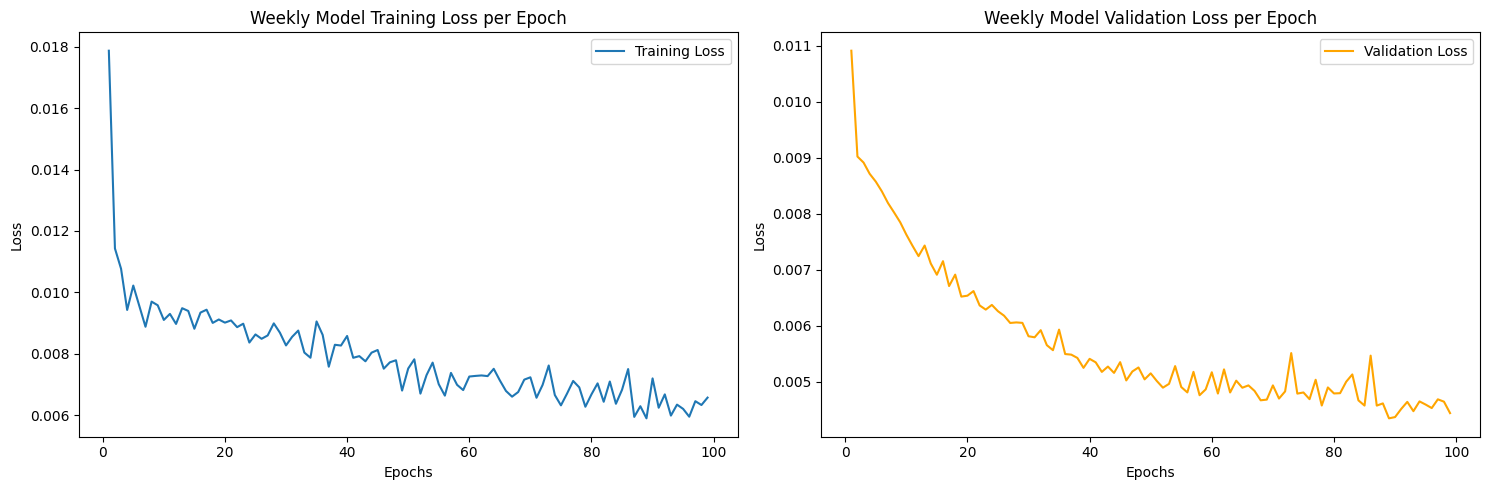

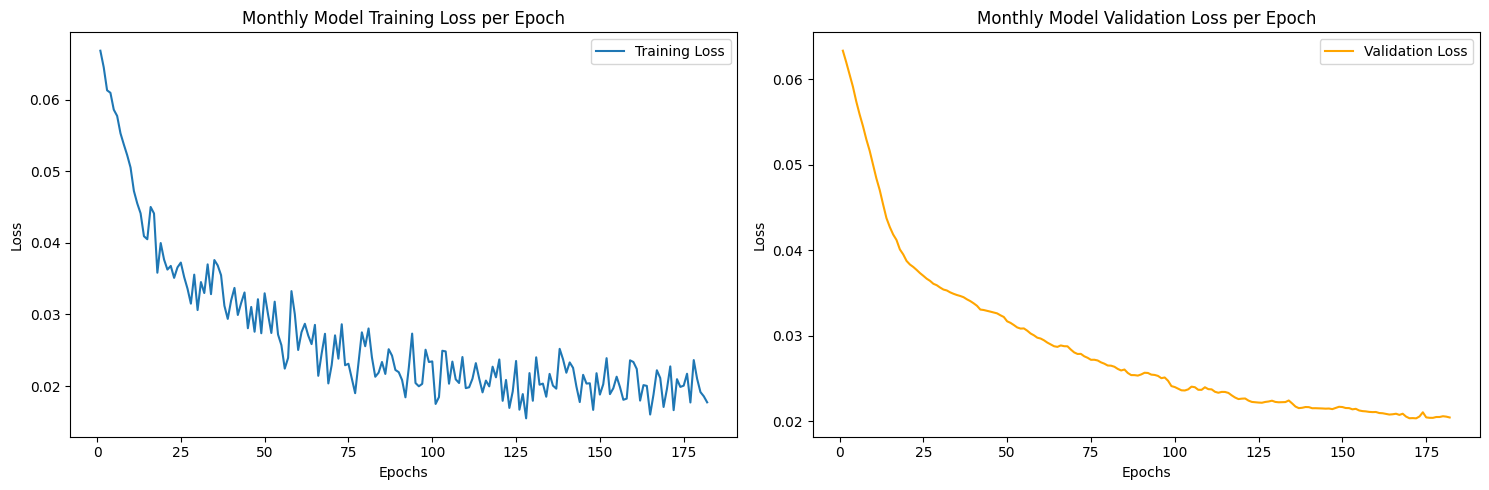

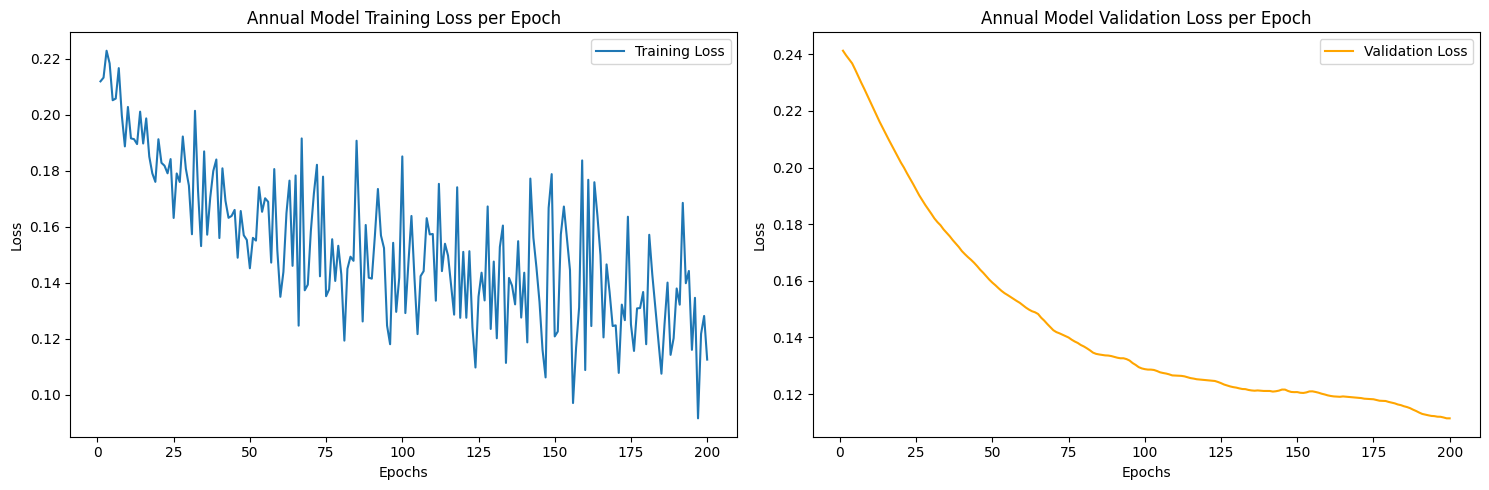

In [18]:
import matplotlib.pyplot as plt

# Get the training and validation loss from the history object for weekly model
train_loss_weekly = history_weekly.history['loss']
val_loss_weekly = history_weekly.history['val_loss']
epochs_weekly = range(1, len(train_loss_weekly) + 1)

# Create a figure with two subplots for weekly model
fig_weekly, axes_weekly = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss for weekly model
axes_weekly[0].plot(epochs_weekly, train_loss_weekly, label='Training Loss')
axes_weekly[0].set_title('Weekly Model Training Loss per Epoch')
axes_weekly[0].set_xlabel('Epochs')
axes_weekly[0].set_ylabel('Loss')
axes_weekly[0].legend()

# Plot validation loss for weekly model
axes_weekly[1].plot(epochs_weekly, val_loss_weekly, label='Validation Loss', color='orange')
axes_weekly[1].set_title('Weekly Model Validation Loss per Epoch')
axes_weekly[1].set_xlabel('Epochs')
axes_weekly[1].set_ylabel('Loss')
axes_weekly[1].legend()

plt.tight_layout()
plt.show()

# Get the training and validation loss from the history object for monthly model
train_loss_monthly = history_monthly.history['loss']
val_loss_monthly = history_monthly.history['val_loss']
epochs_monthly = range(1, len(train_loss_monthly) + 1)

# Create a figure with two subplots for monthly model
fig_monthly, axes_monthly = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss for monthly model
axes_monthly[0].plot(epochs_monthly, train_loss_monthly, label='Training Loss')
axes_monthly[0].set_title('Monthly Model Training Loss per Epoch')
axes_monthly[0].set_xlabel('Epochs')
axes_monthly[0].set_ylabel('Loss')
axes_monthly[0].legend()

# Plot validation loss for monthly model
axes_monthly[1].plot(epochs_monthly, val_loss_monthly, label='Validation Loss', color='orange')
axes_monthly[1].set_title('Monthly Model Validation Loss per Epoch')
axes_monthly[1].set_xlabel('Epochs')
axes_monthly[1].set_ylabel('Loss')
axes_monthly[1].legend()

plt.tight_layout()
plt.show()

# Get the training and validation loss from the history object for annual model
train_loss_annual = history_annual.history['loss']
val_loss_annual = history_annual.history['val_loss']
epochs_annual = range(1, len(train_loss_annual) + 1)

# Create a figure with two subplots for annual model
fig_annual, axes_annual = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss for annual model
axes_annual[0].plot(epochs_annual, train_loss_annual, label='Training Loss')
axes_annual[0].set_title('Annual Model Training Loss per Epoch')
axes_annual[0].set_xlabel('Epochs')
axes_annual[0].set_ylabel('Loss')
axes_annual[0].legend()

# Plot validation loss for annual model
axes_annual[1].plot(epochs_annual, val_loss_annual, label='Validation Loss', color='orange')
axes_annual[1].set_title('Annual Model Validation Loss per Epoch')
axes_annual[1].set_xlabel('Epochs')
axes_annual[1].set_ylabel('Loss')
axes_annual[1].legend()

plt.tight_layout()
plt.show()

# Model Prediction

In [19]:
import numpy as np

### Get the last 5 data points from the scaled weekly data ###
# Let's say I want to predict outbreak for 15/8/2025, so it will take previous past 5 weeks data to make prediction for this week
last_5_weeks_scaled = scaled_features[-5:]

# Reshape the input for the LSTM model (samples, timesteps, features) (1, 5, 2)
# scaled_features.shape[1] -> our target date (15/8/2025)
input_sequence_weekly = last_5_weeks_scaled.reshape(1, 5, scaled_features.shape[1])

### Make the prediction for weekly data ###
scaled_prediction_weekly = model_weekly.predict(input_sequence_weekly)

# Inverse transform the scaled prediction to get the actual outbreak count
# This part let's say I get result 0.25, so this is scaled result, then we need to inverse the 0.25 to actual number outbreak (maybe 2. something outbreaks)
dummy_array_weekly = np.zeros((scaled_prediction_weekly.shape[0], scaled_features.shape[1]))
dummy_array_weekly[:, 0] = scaled_prediction_weekly[:, 0]
actual_prediction_weekly = scaler.inverse_transform(dummy_array_weekly)[:, 0]

print(f"Predicted outbreak count for the next week: {actual_prediction_weekly[0]:.2f}\n")

### Get the last 3 data points from the scaled monthly data (take last 3 weeks for understanding) ###
# Steps are same as weekly prediction
last_3_months_scaled = scaled_monthly_features[-3:]

# Reshape the input for the monthly LSTM model
input_sequence_monthly = last_3_months_scaled.reshape(1, 3, scaled_monthly_features.shape[1])

# Make the prediction for monthly data
scaled_prediction_monthly = model_monthly.predict(input_sequence_monthly)

# Inverse transform the scaled prediction for monthly data
dummy_array_monthly = np.zeros((scaled_prediction_monthly.shape[0], scaled_monthly_features.shape[1]))
dummy_array_monthly[:, 0] = scaled_prediction_monthly[:, 0]
actual_prediction_monthly = monthly_scaler.inverse_transform(dummy_array_monthly)[:, 0]

print(f"Predicted outbreak count for the next month: {actual_prediction_monthly[0]:.2f}\n")


### Get the last 2 data points from the scaled annual data ###
last_2_years_scaled = scaled_annual_features[-2:]

# Reshape the input for the annual LSTM model
input_sequence_annual = last_2_years_scaled.reshape(1, 2, scaled_annual_features.shape[1])

# Make the prediction for annual data
scaled_prediction_annual = model_annual.predict(input_sequence_annual)

# Inverse transform the scaled prediction for annual data
dummy_array_annual = np.zeros((scaled_prediction_annual.shape[0], scaled_annual_features.shape[1]))
dummy_array_annual[:, 0] = scaled_prediction_annual[:, 0]
actual_prediction_annual = annual_scaler.inverse_transform(dummy_array_annual)[:, 0]

print(f"Predicted outbreak count for the next year: {actual_prediction_annual[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Predicted outbreak count for the next week: 3.24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted outbreak count for the next month: 7.53

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Predicted outbreak count for the next year: 98.26


# Prediction on testing set to visualise the model performance

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


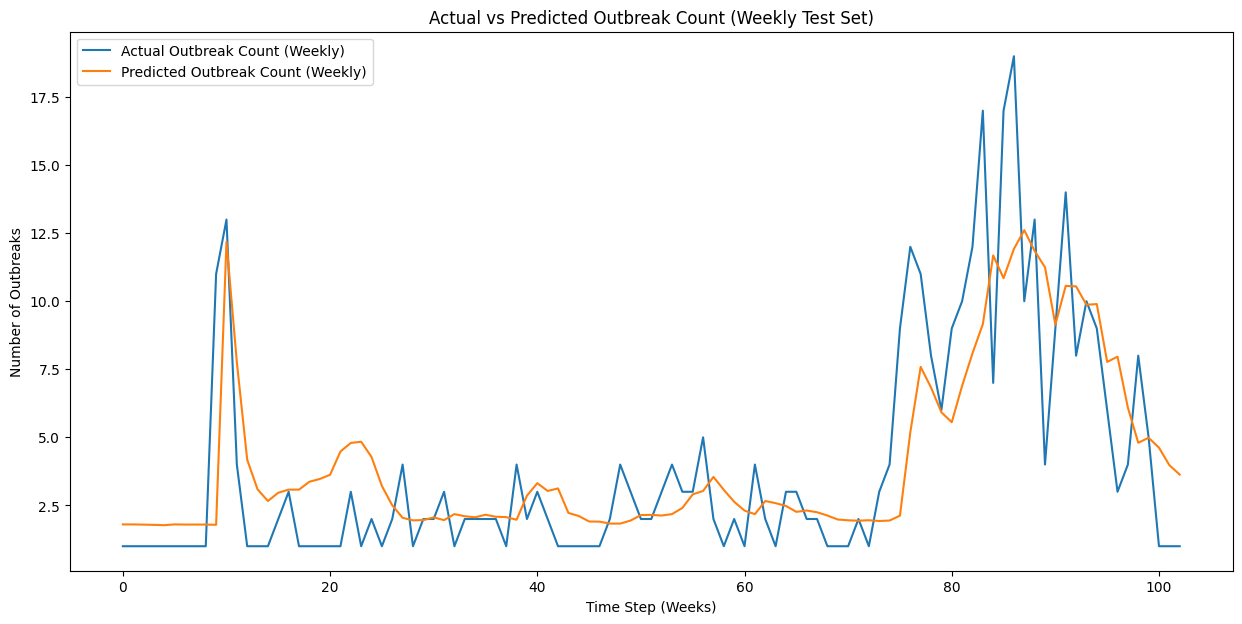

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


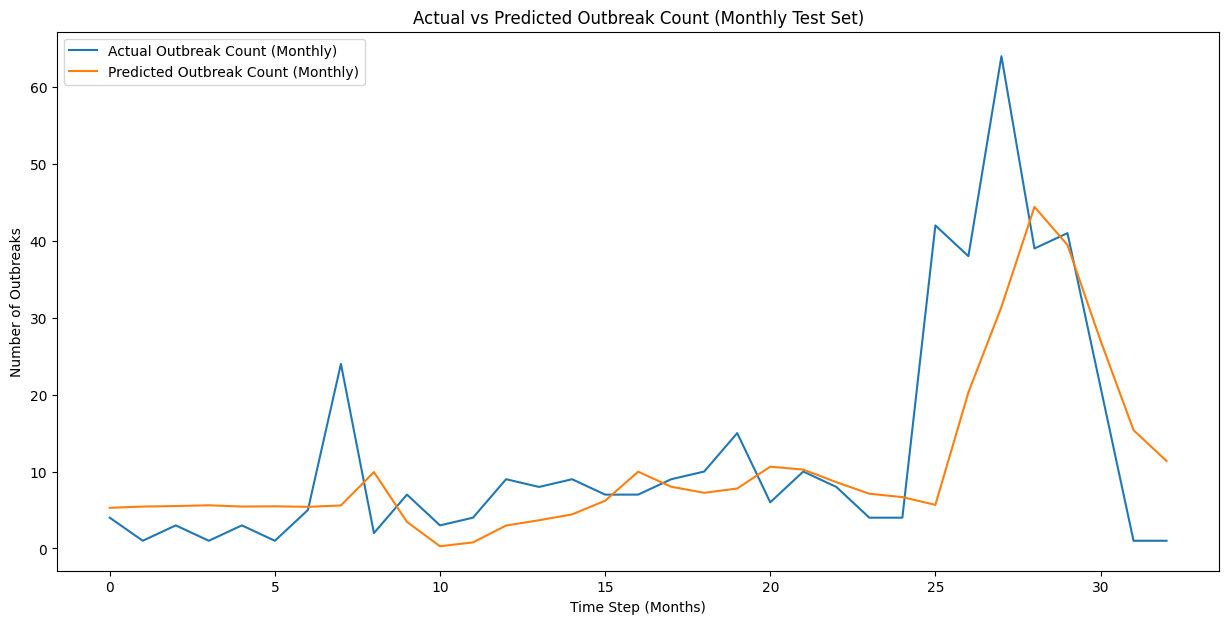

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


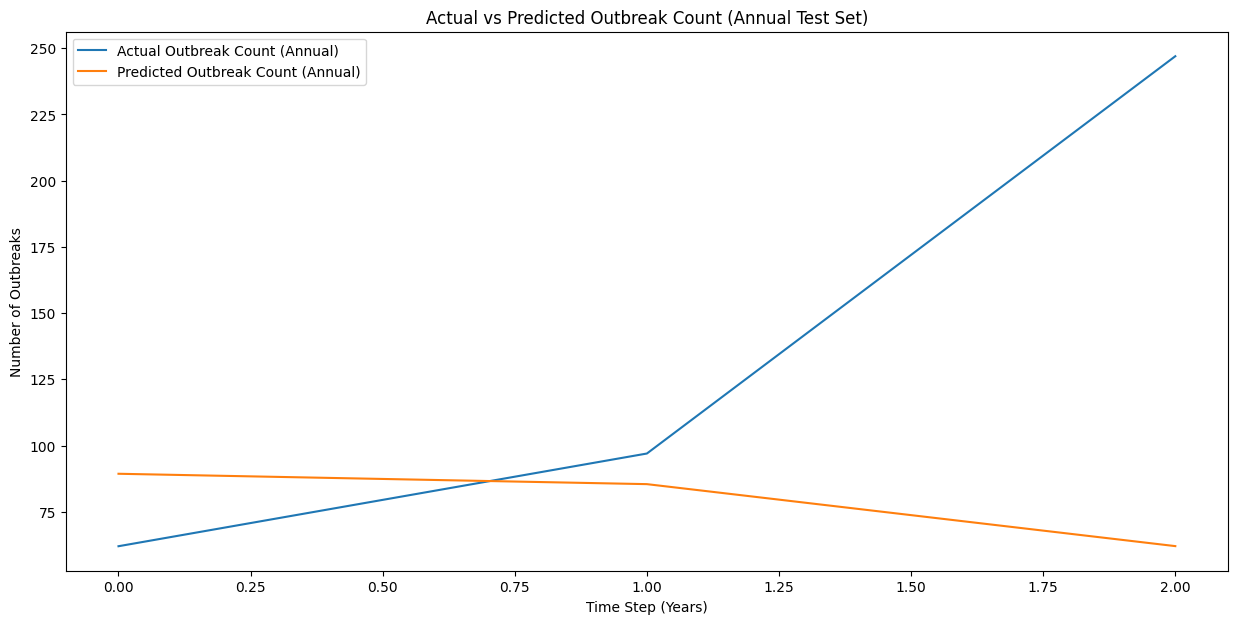

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_weekly and y_weekly are the sequences created for training and testing for weekly data
# Assuming the validation split was 0.2, the last 20% of X_weekly and y_weekly are the validation/test set
split_index_weekly = int(len(X_weekly) * 0.8)
X_test_weekly = X_weekly[split_index_weekly:]
y_test_weekly = y_weekly[split_index_weekly:]

# Make predictions on the weekly test set (20%)
scaled_test_predictions_weekly = model_weekly.predict(X_test_weekly)

# Inverse transform the actual weekly test values and the predictions (since we do the scaling during training, so we need to inverse the scale to normal number)
actual_test_outbreaks_weekly = np.zeros((len(y_test_weekly), scaled_features.shape[1]))
actual_test_outbreaks_weekly[:, 0] = y_test_weekly
actual_test_outbreaks_weekly = scaler.inverse_transform(actual_test_outbreaks_weekly)[:, 0]

predicted_test_outbreaks_weekly = np.zeros((len(scaled_test_predictions_weekly), scaled_features.shape[1]))
predicted_test_outbreaks_weekly[:, 0] = scaled_test_predictions_weekly[:, 0]
predicted_test_outbreaks_weekly = scaler.inverse_transform(predicted_test_outbreaks_weekly)[:, 0]

# Plot the comparison for weekly data
plt.figure(figsize=(15, 7))
plt.plot(actual_test_outbreaks_weekly, label='Actual Outbreak Count (Weekly)')
plt.plot(predicted_test_outbreaks_weekly, label='Predicted Outbreak Count (Weekly)')
plt.title('Actual vs Predicted Outbreak Count (Weekly Test Set)')
plt.xlabel('Time Step (Weeks)')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.show()

# Assuming X_monthly and y_monthly are the sequences created for training and testing for monthly data
# Assuming the validation split was 0.2, the last 20% of X_monthly and y_monthly are the validation/test set
split_index_monthly = int(len(X_monthly) * 0.8)
X_test_monthly = X_monthly[split_index_monthly:]
y_test_monthly = y_monthly[split_index_monthly:]

# Make predictions on the monthly test set
scaled_test_predictions_monthly = model_monthly.predict(X_test_monthly)

# Inverse transform the actual monthly test values and the predictions
actual_test_outbreaks_monthly = np.zeros((len(y_test_monthly), scaled_monthly_features.shape[1]))
actual_test_outbreaks_monthly[:, 0] = y_test_monthly
actual_test_outbreaks_monthly = monthly_scaler.inverse_transform(actual_test_outbreaks_monthly)[:, 0]

predicted_test_outbreaks_monthly = np.zeros((len(scaled_test_predictions_monthly), scaled_monthly_features.shape[1]))
predicted_test_outbreaks_monthly[:, 0] = scaled_test_predictions_monthly[:, 0]
predicted_test_outbreaks_monthly = monthly_scaler.inverse_transform(predicted_test_outbreaks_monthly)[:, 0]

# Plot the comparison for monthly data
plt.figure(figsize=(15, 7))
plt.plot(actual_test_outbreaks_monthly, label='Actual Outbreak Count (Monthly)')
plt.plot(predicted_test_outbreaks_monthly, label='Predicted Outbreak Count (Monthly)')
plt.title('Actual vs Predicted Outbreak Count (Monthly Test Set)')
plt.xlabel('Time Step (Months)')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.show()

# Assuming X_annual and y_annual are the sequences created for training and testing for annual data
# Assuming the validation split was 0.2, the last 20% of X_annual and y_annual are the validation/test set
split_index_annual = int(len(X_annual) * 0.8)
X_test_annual = X_annual[split_index_annual:]
y_test_annual = y_annual[split_index_annual:]

# Make predictions on the annual test set
scaled_test_predictions_annual = model_annual.predict(X_test_annual)

# Inverse transform the actual annual test values and the predictions
actual_test_outbreaks_annual = np.zeros((len(y_test_annual), scaled_annual_features.shape[1]))
actual_test_outbreaks_annual[:, 0] = y_test_annual
actual_test_outbreaks_annual = annual_scaler.inverse_transform(actual_test_outbreaks_annual)[:, 0]

predicted_test_outbreaks_annual = np.zeros((len(scaled_test_predictions_annual), scaled_annual_features.shape[1]))
predicted_test_outbreaks_annual[:, 0] = scaled_test_predictions_annual[:, 0]
predicted_test_outbreaks_annual = annual_scaler.inverse_transform(predicted_test_outbreaks_annual)[:, 0]

# Plot the comparison for annual data
plt.figure(figsize=(15, 7))
plt.plot(actual_test_outbreaks_annual, label='Actual Outbreak Count (Annual)')
plt.plot(predicted_test_outbreaks_annual, label='Predicted Outbreak Count (Annual)')
plt.title('Actual vs Predicted Outbreak Count (Annual Test Set)')
plt.xlabel('Time Step (Years)')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.show()

# Visualise the value of actual and predicted data

In [21]:
import pandas as pd

# Create a DataFrame with actual and predicted values for weekly data
results_df_weekly = pd.DataFrame({
    'Actual Outbreaks (Weekly)': actual_test_outbreaks_weekly,
    'Predicted Outbreaks (Weekly)': predicted_test_outbreaks_weekly
})

print("Weekly Results:")
display(results_df_weekly)

# Create a DataFrame with actual and predicted values for monthly data
results_df_monthly = pd.DataFrame({
    'Actual Outbreaks (Monthly)': actual_test_outbreaks_monthly,
    'Predicted Outbreaks (Monthly)': predicted_test_outbreaks_monthly
})

print("\nMonthly Results:")
display(results_df_monthly)

# Create a DataFrame with actual and predicted values for annual data
results_df_annual = pd.DataFrame({
    'Actual Outbreaks (Annual)': actual_test_outbreaks_annual,
    'Predicted Outbreaks (Annual)': predicted_test_outbreaks_annual
})

print("\nAnnual Results:")
display(results_df_annual)

Weekly Results:


,Actual Outbreaks (Weekly),Predicted Outbreaks (Weekly)
0,1.0,1.801229
1,1.0,1.800669
2,1.0,1.793663
3,1.0,1.784558
4,1.0,1.773317
...,...,...
98,8.0,4.800919
99,5.0,4.983593
100,1.0,4.621484
101,1.0,3.979696



Monthly Results:


,Actual Outbreaks (Monthly),Predicted Outbreaks (Monthly)
0,4.0,5.284171
1,1.0,5.446244
2,3.0,5.514089
3,1.0,5.612300
4,3.0,5.448285
5,1.0,5.479461
6,5.0,5.411997
7,24.0,5.590425
8,2.0,9.931476
9,7.0,3.451671



Annual Results:


,Actual Outbreaks (Annual),Predicted Outbreaks (Annual)
0,62.0,89.356920
1,97.0,85.439007
2,247.0,62.038420


# Save models for website usage

In [22]:
import shutil
import os

# Save the trained models locally
model_weekly.save('outbreak_prediction_model_weekly.keras')
model_monthly.save('outbreak_prediction_model_monthly.keras')
model_annual.save('outbreak_prediction_model_annual.keras')


print("Models saved locally successfully!")

Models saved locally successfully!
